In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import Lasso, Ridge, LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, train_test_split
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import warnings

warnings.filterwarnings("ignore")

# Driver Data

In [3]:
df=pd.read_csv("driver.csv")
display(df)

,DRIVER_ID,DRIVER_NAME,AGE,LICENSE_DETAILS,NUMBER_OF_TRIPS,SAFETY_SCORE,RANK,REWARD_POINTS,TOTAL_MILES_DONE,MILES_IN_URBAN,MILES_IN_NIGHT,MILES DONE IN RURAL,ACCELERATION,BRAKING,CORNERING,SPEEDING,SEATBELT,DISTRACTION,NUMBER_OF_TICKETS_RECEIVED
0,200,Lillie Reed,54,ikGb-hJMJtY,825,92,0,9341,668074,985656,825054,2478784,48,61,4,40,41,8,19
1,201,James Cannady,21,9YR2HBmcrpo,232,94,0,2926,457748,269133,486095,1212976,50,59,24,73,25,4,0
2,202,Robert Powers,43,qmWPXX4ez5Y,734,51,0,5866,527962,359125,707468,1594555,13,25,54,1,57,49,23
3,203,Ella Devault,20,o81UfAD57ts,481,83,0,875,855197,525276,773708,2154181,55,50,23,46,62,51,23
4,204,Desiree Vanleuven,53,bTrBLvOpGoo,335,76,0,4016,756332,238520,269453,1264305,71,17,72,52,39,11,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,445,Monica Cooks,47,vuRxst39xi8,168,95,0,7422,973746,265568,180169,1419483,4,68,28,64,20,61,8
246,446,Chad Hall,24,RgLmnQDNw-I,190,90,0,6401,632816,540134,462190,1635140,41,46,47,39,36,8,4
247,447,Irene Schneider,33,CTWfBBNmcjE,241,70,0,9672,15941,29818,918461,964220,39,65,64,74,26,69,0
248,448,Ralph Poteet,30,CpOtKSN15qY,750,47,0,6363,291372,414021,139156,844549,40,67,61,73,14,13,0


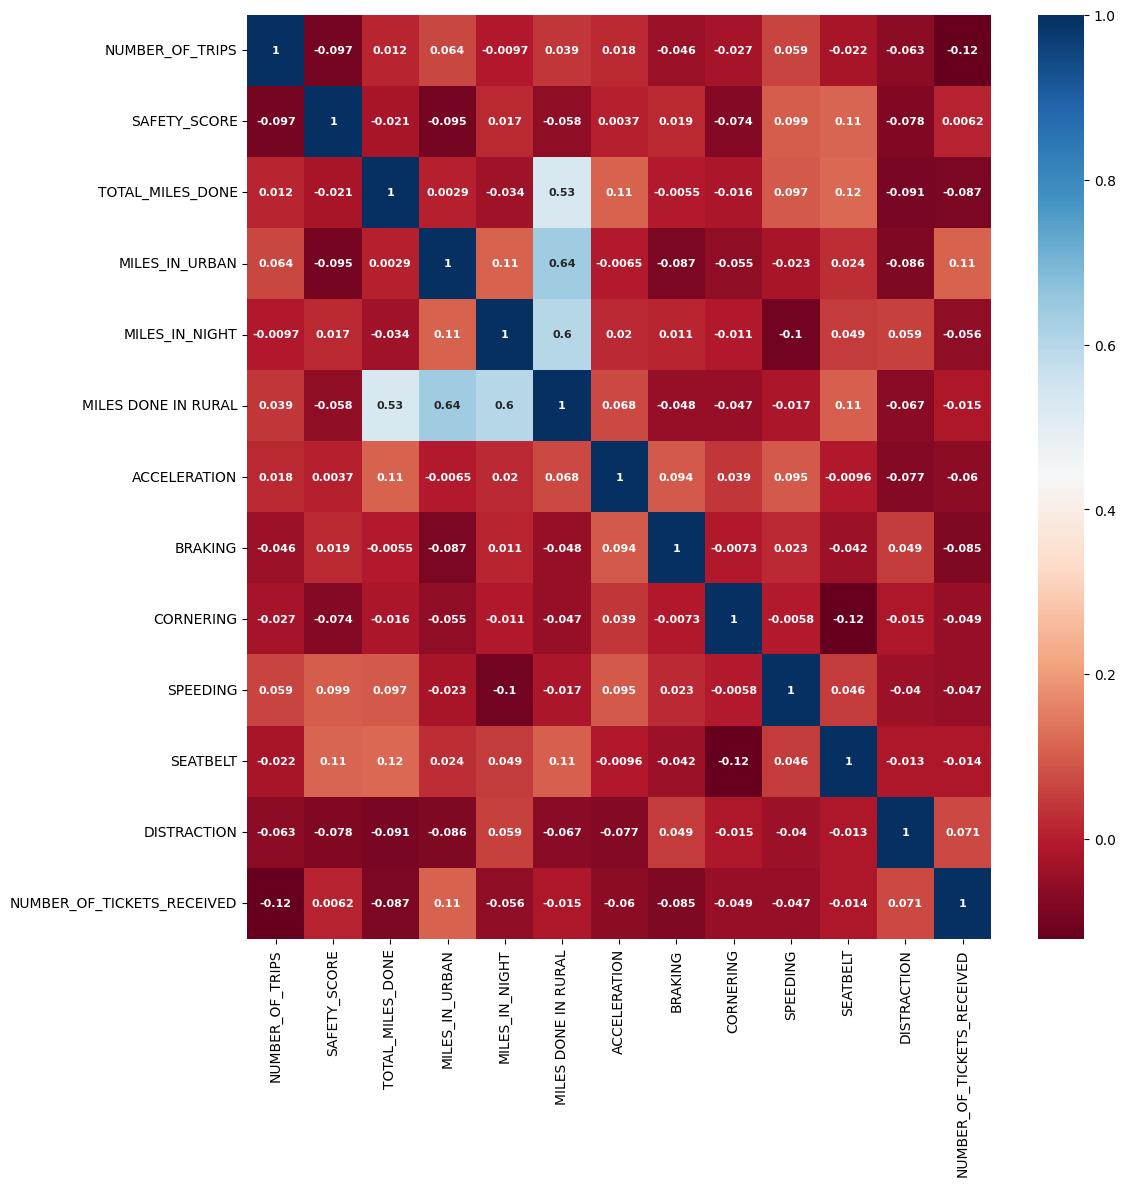

In [4]:
df=pd.read_csv("driver.csv")
columns_list=list(df.columns)

corr_columns=columns_list[4:6]+columns_list[8:]
corr_df=df[corr_columns]
corr=corr_df.corr()

plt.figure(figsize=((12,12)))
sns.heatmap(corr, cmap='RdBu', annot=True, annot_kws={'fontsize':8, 'fontweight':'bold'})
plt.show()

We observe here that all numeric columns in the data frame have nearly negligible correlations, with the exception of the miles variables- although this correlation is to be expected, of course. Interestingly, safety score doesn't have a significant correlation with any of the other parameters. This is not a very good sign, although we'll try to build around this. Next, let's analyse the distributions of each of the numerical columns, and try to infer information about the generation of data from this.

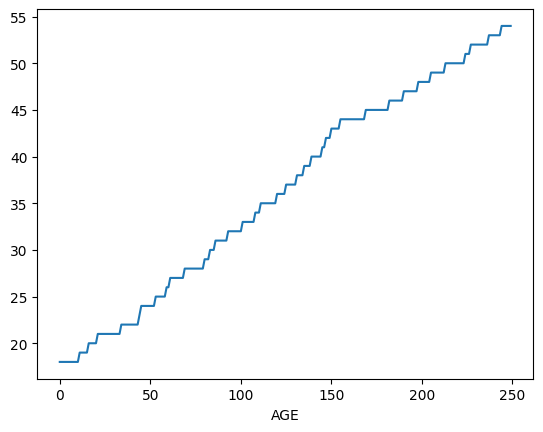

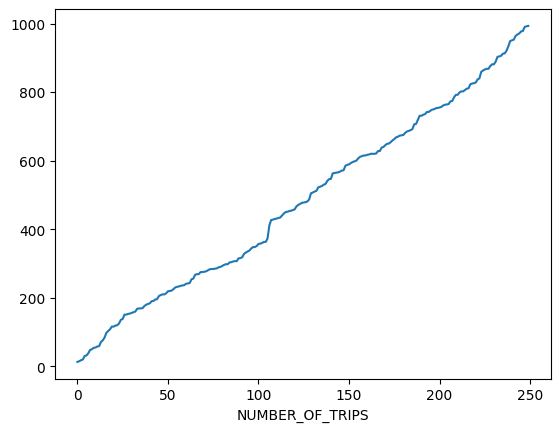

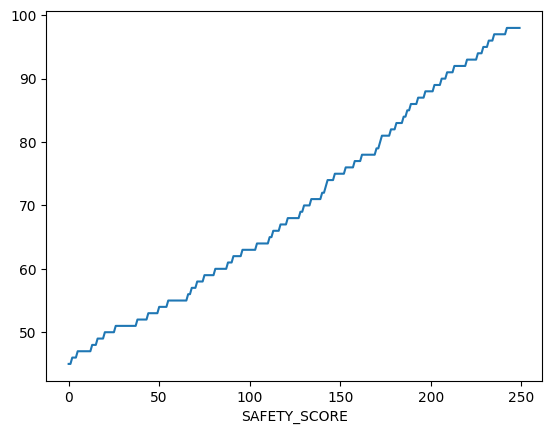

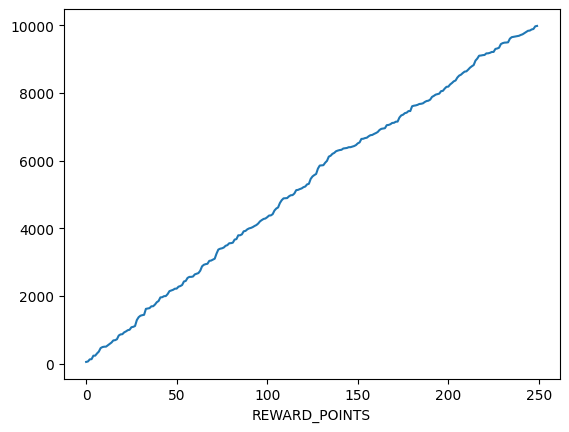

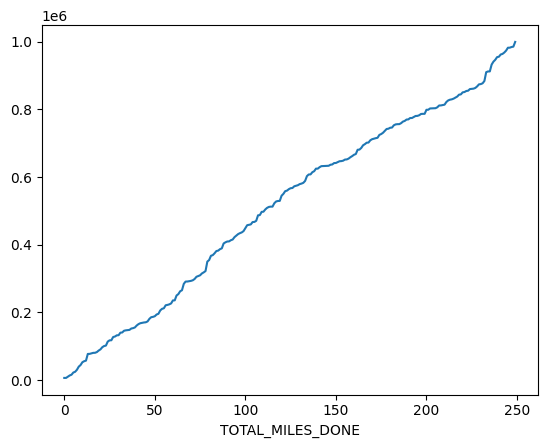

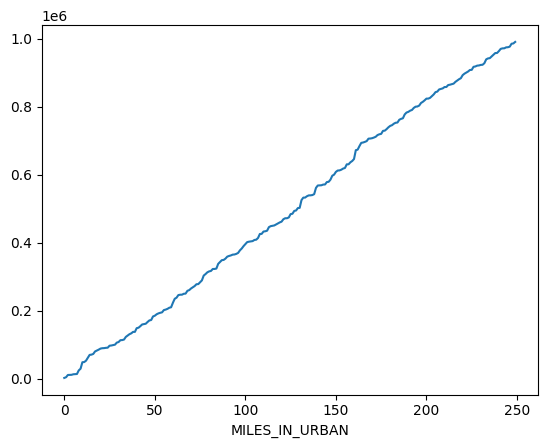

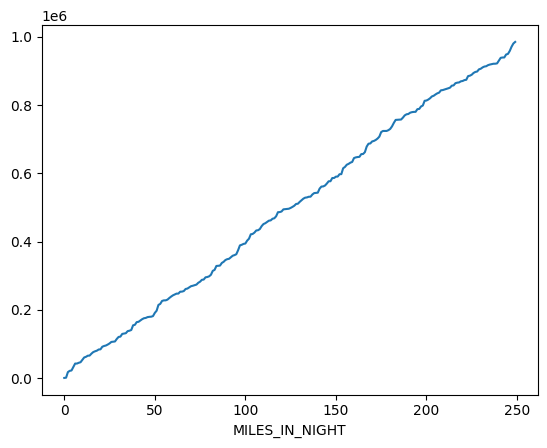

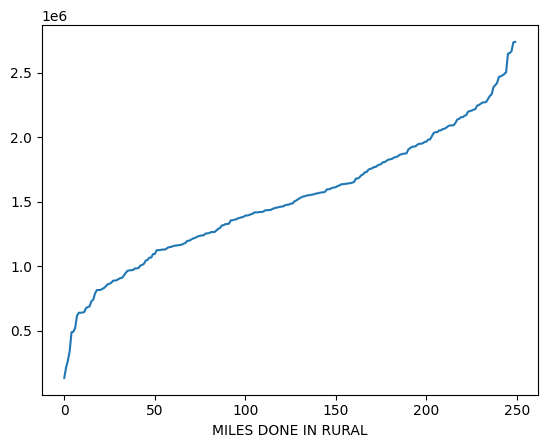

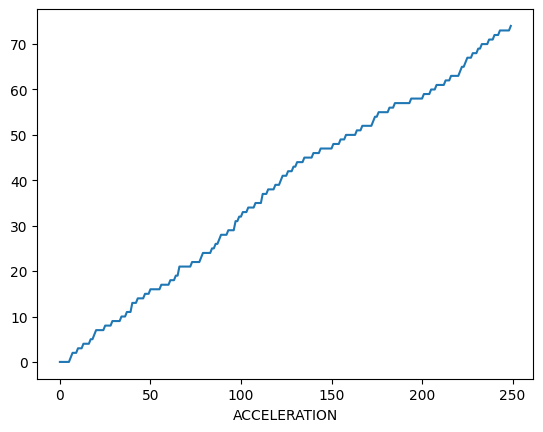

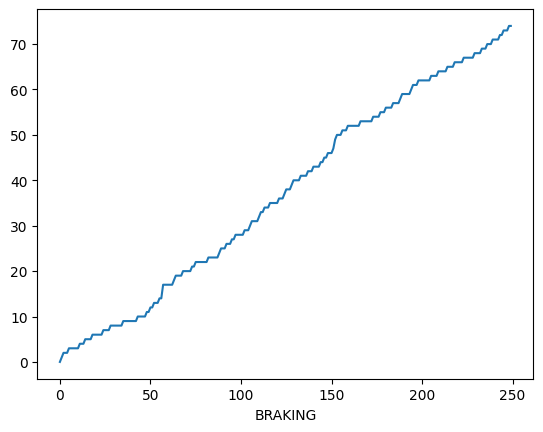

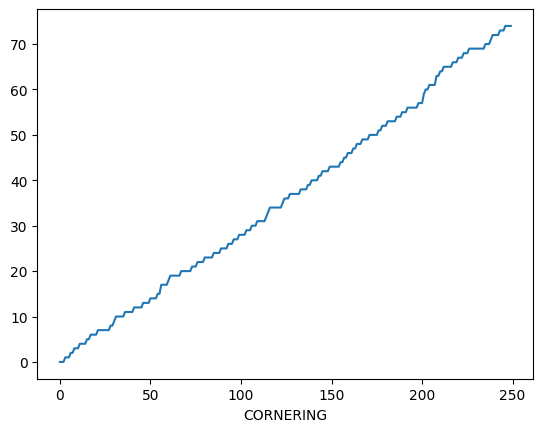

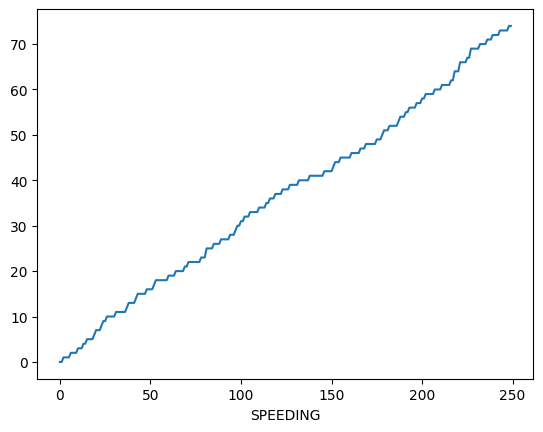

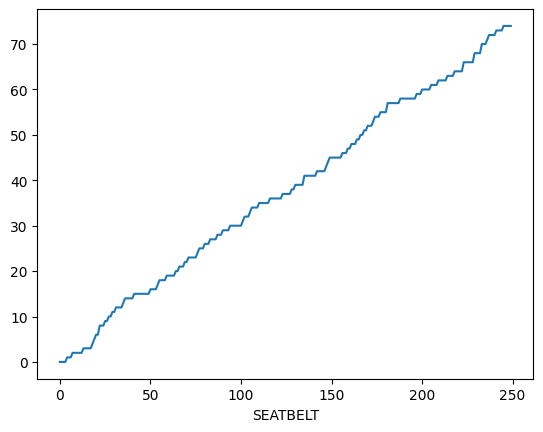

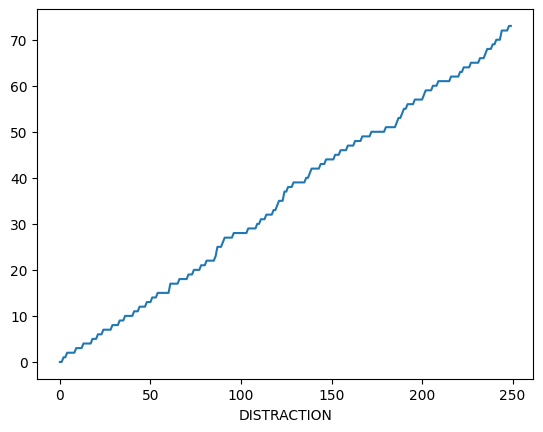

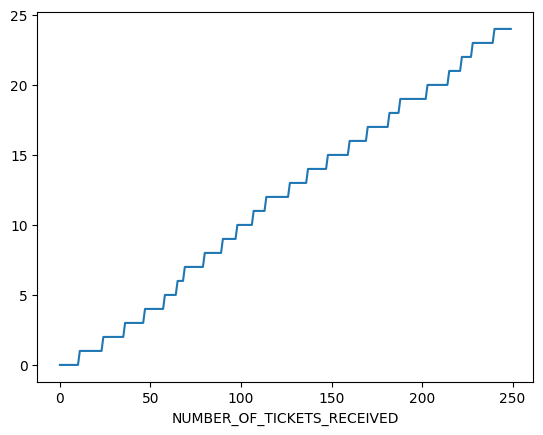

In [5]:
df=pd.read_csv("driver.csv")
columns_list=list(df.columns)

for col in df.columns:
    if col not in ["DRIVER_ID", "DRIVER_NAME", "LICENSE_DETAILS", "RANK"]:
        column=np.array(df[col])
        column.sort()
        plt.plot(column)
        plt.xlabel(col)
        plt.show()

Looking at the Cumulative Distribution Functions (with flipped x/y axes) of each numeric column, one can tell that each variable is uniformly distributed, with the exception of "MILES DONE IN RURAL", which looks to be normally distributed. This tells us that any relationship involving the variables for the computation of safety score must be essentially linear in nature.

In [6]:
df=pd.read_csv("driver.csv")
columns_list=list(df.columns)

num_columns=[]
for col in columns_list:
    if col not in ["DRIVER_ID", "DRIVER_NAME", "LICENSE_DETAILS", "RANK"]:
        num_columns.append(col)

norm_df=df[num_columns]

scaler=MinMaxScaler()
norm_df[num_columns]=scaler.fit_transform(norm_df[num_columns])

In [7]:
x_col=['AGE', 'NUMBER_OF_TRIPS', 'REWARD_POINTS', 'MILES_IN_URBAN', 'CORNERING', 'SPEEDING', 'SEATBELT', 'DISTRACTION']

X_df=norm_df[x_col]
Y_df=norm_df["SAFETY_SCORE"]

X_train, X_testval, Y_train, Y_testval = train_test_split(X_df, Y_df, test_size=0.3, random_state=0)
X_test, X_val, Y_test, Y_val = train_test_split(X_testval, Y_testval, test_size=0.5, random_state=22)

model=LinearRegression()
model.fit(X_train, Y_train)
Y_pred=model.predict(X_test)

x_coef=dict(np.array([x_col, model.coef_]).T)

print("Score of Linear Regression:", explained_variance_score(Y_test, Y_pred))

Score of Linear Regression: 0.0920998704670365


In [8]:
x_col=['AGE', 'NUMBER_OF_TRIPS', 'REWARD_POINTS', 'MILES_IN_URBAN', 'CORNERING', 'SPEEDING', 'SEATBELT', 'DISTRACTION']

X_df=norm_df[x_col]
Y_df=norm_df["SAFETY_SCORE"]*100

X_train, X_testval, Y_train, Y_testval = train_test_split(X_df, Y_df, test_size=0.3, random_state=0)
X_test, X_val, Y_test, Y_val = train_test_split(X_testval, Y_testval, test_size=0.5, random_state=22)

model=Lasso()

parameters={"alpha": np.linspace(0.01, 20, 100)}
grid_search=GridSearchCV(model, parameters, scoring="explained_variance", cv=3, verbose=0)
grid_search.fit(X_train, Y_train)

print("Best parameters for Lasso:", grid_search.best_params_)

best_params=grid_search.best_params_

model=Lasso(best_params["alpha"])
model.fit(X_train, Y_train)
Y_pred=model.predict(X_test)

x_coef=dict(np.array([x_col, model.coef_]).T)

print("Score of Lasso Regression:", explained_variance_score(Y_test, Y_pred))

Best parameters for Lasso: {'alpha': 0.41383838383838384}
Score of Lasso Regression: 0.0397073626495944


In [9]:
degree=2

polyreg=make_pipeline(PolynomialFeatures(degree=degree), Lasso())
parameters={"lasso__alpha": np.linspace(0.01, 0.8, 50)}
gridsearch=GridSearchCV(polyreg, parameters, scoring="explained_variance", cv=3, verbose=0)
gridsearch.fit(X_df, Y_df)

print("Best parameters for Polynomial Lasso:", gridsearch.best_params_)

best_params=gridsearch.best_params_  #poly_model["lasso"] to refer to lass

Best parameters for Polynomial Lasso: {'lasso__alpha': 0.4453061224489796}


In [10]:
poly_model=make_pipeline(PolynomialFeatures(degree=degree), Lasso(alpha=best_params["lasso__alpha"]))
poly_model.fit(X_train, Y_train)

Y_pred=poly_model.predict(X_test)
print("Score of Polynomial Lasso:", explained_variance_score(Y_test, Y_pred))

Score of Polynomial Lasso: 0.019203450829252677


In [11]:
parameters={"splitter":["best","random"],
            "max_depth" : [2,3,6],
            "max_leaf_nodes": [5,10],
           "min_samples_leaf":[5,10,20,30],
           "random_state": [0]}

dtree_tuner=DecisionTreeRegressor()
tuning_model=GridSearchCV(dtree_tuner, param_grid=parameters, scoring="explained_variance", cv=3, verbose=0)
tuning_model.fit(X_df, Y_df)

best_params=tuning_model.best_params_

print("Best params:", tuning_model.best_params_)

Best params: {'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_leaf': 30, 'random_state': 0, 'splitter': 'random'}


Score of Decision Tree Regressor: -0.04315533820998696


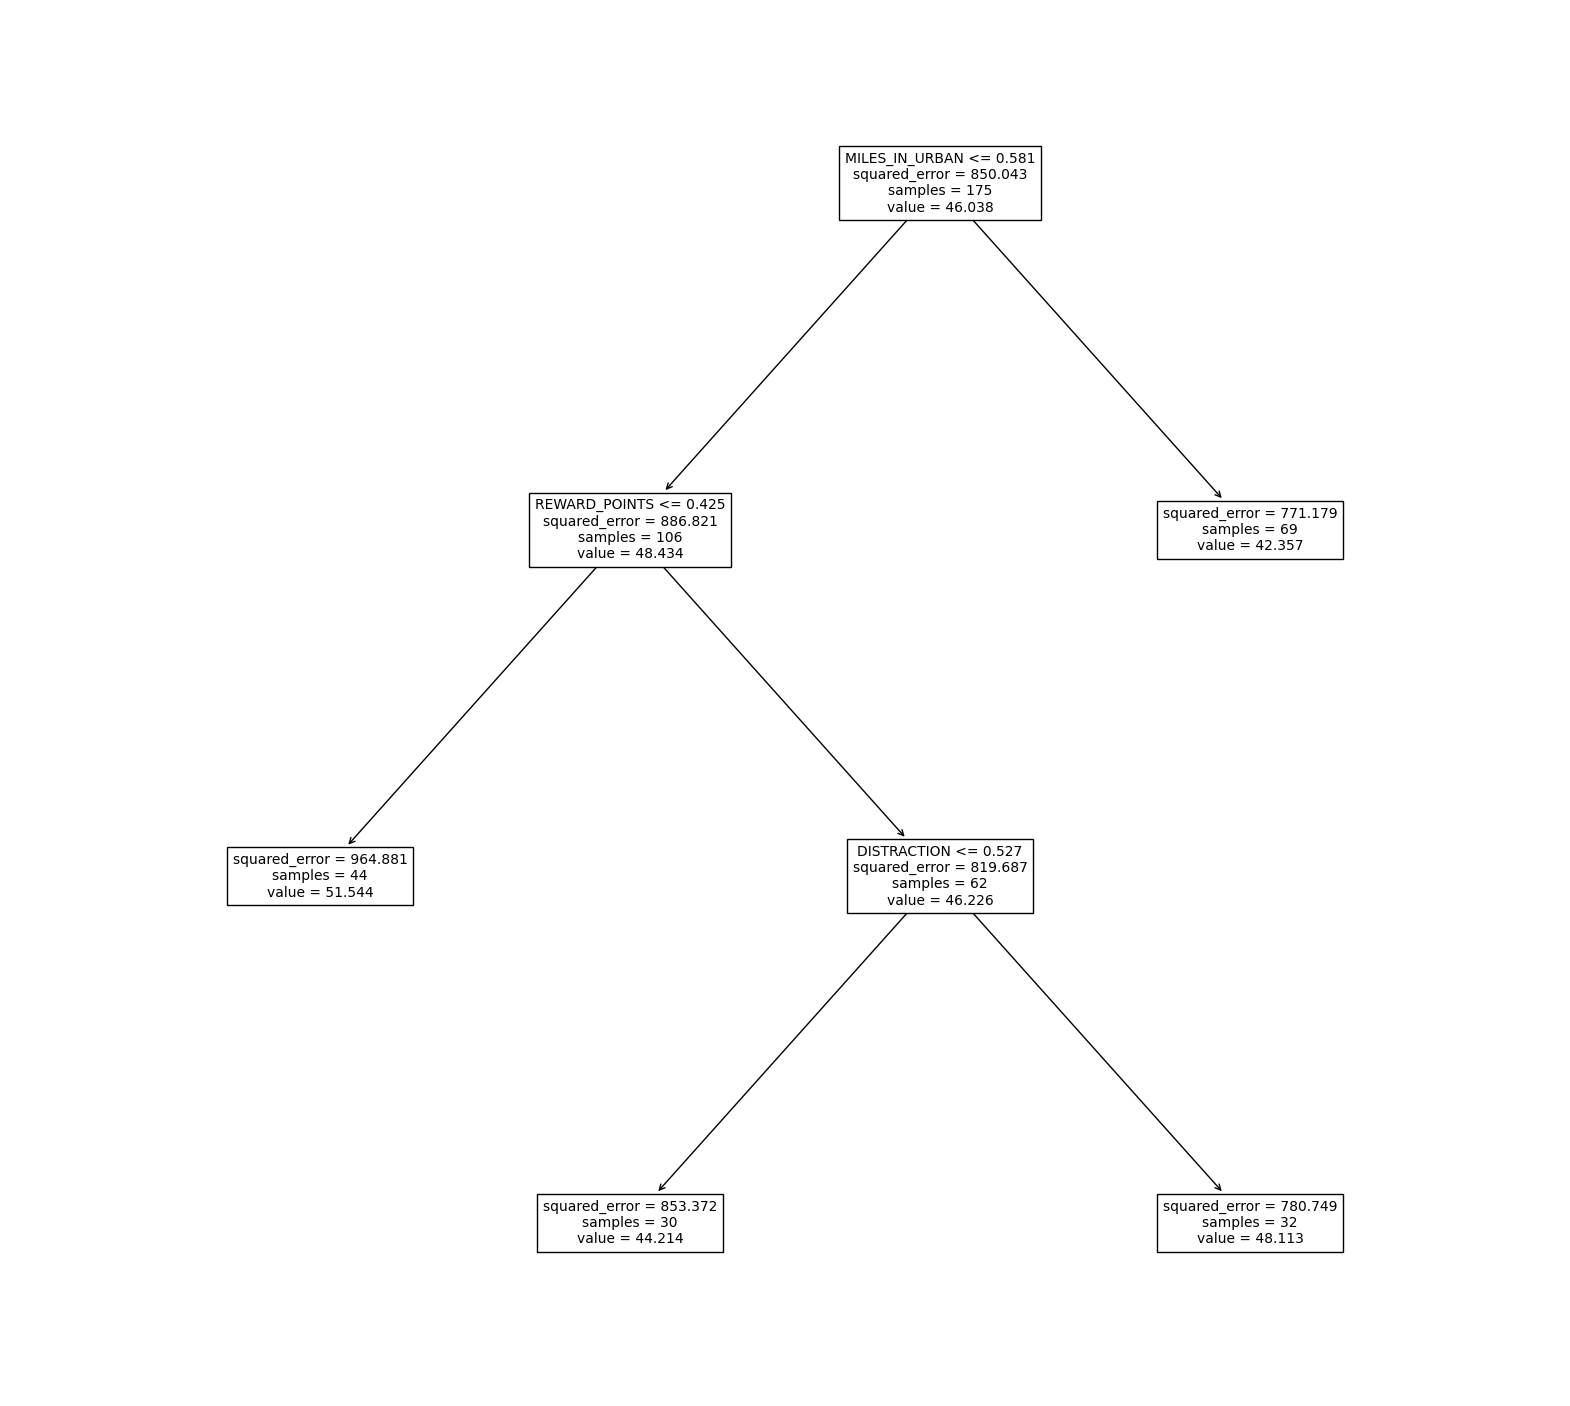

In [12]:
dtree=DecisionTreeRegressor(max_depth=best_params["max_depth"], min_samples_leaf=best_params["min_samples_leaf"], splitter=best_params["splitter"],
                           random_state=0)
dtree.fit(X_train, Y_train)

plt.figure(figsize=(20,18))
tree.plot_tree(dtree, feature_names=x_col, fontsize=10)

Y_pred=dtree.predict(X_test)

print("Score of Decision Tree Regressor:", explained_variance_score(Y_test, Y_pred))

In [13]:
parameters = {'n_estimators': [55],
               'max_features': ['sqrt'],
               'max_depth': [2,3,4],
               'min_samples_split': [2,3,6],
               'min_samples_leaf': [15,20],
                'max_leaf_nodes': [5,10,50],
               'warm_start': [True],
              'random_state': [0]
             }

rftree_tuner=RandomForestRegressor()
tuning_model=GridSearchCV(rftree_tuner, param_grid=parameters, scoring="explained_variance", cv=2, verbose=0)
tuning_model.fit(X_df, Y_df)

best_params=tuning_model.best_params_

print("Best params:", tuning_model.best_params_)

Best params: {'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 55, 'random_state': 0, 'warm_start': True}


In [14]:
regr = RandomForestRegressor(max_depth=best_params["max_depth"], max_features=best_params["max_features"], min_samples_leaf=best_params["min_samples_leaf"],
                             min_samples_split=best_params["min_samples_split"], n_estimators=best_params["n_estimators"], random_state=0)
regr.fit(X_train,Y_train)
Y_rf_predict=(regr.predict(X_test))

print("Score of Random Forest Regressor:", explained_variance_score(Y_test, Y_rf_predict))

Score of Random Forest Regressor: 0.03081052238382842


# Vehicle Data

In [15]:
df=pd.read_csv("vehicle.csv")
display(df)

,ID,LICENSE_PLATE,REGISTERED_STATE,SAFETY_SCORE,MAKE,MODEL,YEAR,TOTAL_MILES_DONE,CAPACITY,BATTERY_HEALTH,BATTERY_VOLTAGE,TYRE_PRESSURE,FUEL_LEVEL,OIL_LEVEL,DASH_CAM_IP,LAST_SERVICE_DATE,LAST_SERVICE_MILES,NEXT_SERVICE_DATE,NEXT_SERVICE_MILES
0,1000,NH-6402,NH,82,Arcimoto,Gamma,2009,11654,STD,AVERAGE,13,32,71,20,138.191.25.244,1616152135531,10212,1630262319248,15294
1,1001,WY-6789,WY,82,Suzuki Motor,Delta,2011,36206,XL LARGE,GOOD,13,30,85,11,85.88.33.73,1625761876377,27133,1636461484817,43773
2,1002,HI-2699,HI,69,FAW Car,Alpha,2020,79018,XL LARGE,GOOD,13,33,49,69,140.5.135.253,1621564806588,75031,1639678276738,82724
3,1003,MS-9927,MS,53,Honda,Epsilon,2008,75135,XL LARGE,GOOD,13,34,33,2,184.216.240.204,1612904448086,66876,1632485799734,80555
4,1004,IA-8332,IA,96,SAIC Motor,Zeta,2007,51140,XL LARGE,GOOD,14,33,91,98,194.147.229.93,1621098817128,44880,1638221411413,58814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1245,KS-7026,KS,80,General Motors,Alpha,2020,70593,LARGE,GOOD,14,30,78,31,202.41.167.121,1611946495089,61514,1640046151525,72199
246,1246,AK-4422,AK,93,Subaru,Delta,2006,45928,STD,GOOD,14,30,57,52,144.232.141.116,1610633829532,39135,1641037743208,46486
247,1247,GA-9384,GA,89,Suzuki Motor,Beta,2010,37845,XL LARGE,AVERAGE,12,31,5,7,40.86.190.178,1620601955719,29519,1639765182049,46874
248,1248,OH-6693,OH,89,FAW Car,Alpha,2011,62907,LARGE,AVERAGE,14,34,85,67,127.210.157.58,1621140575933,58364,1633511805631,69593


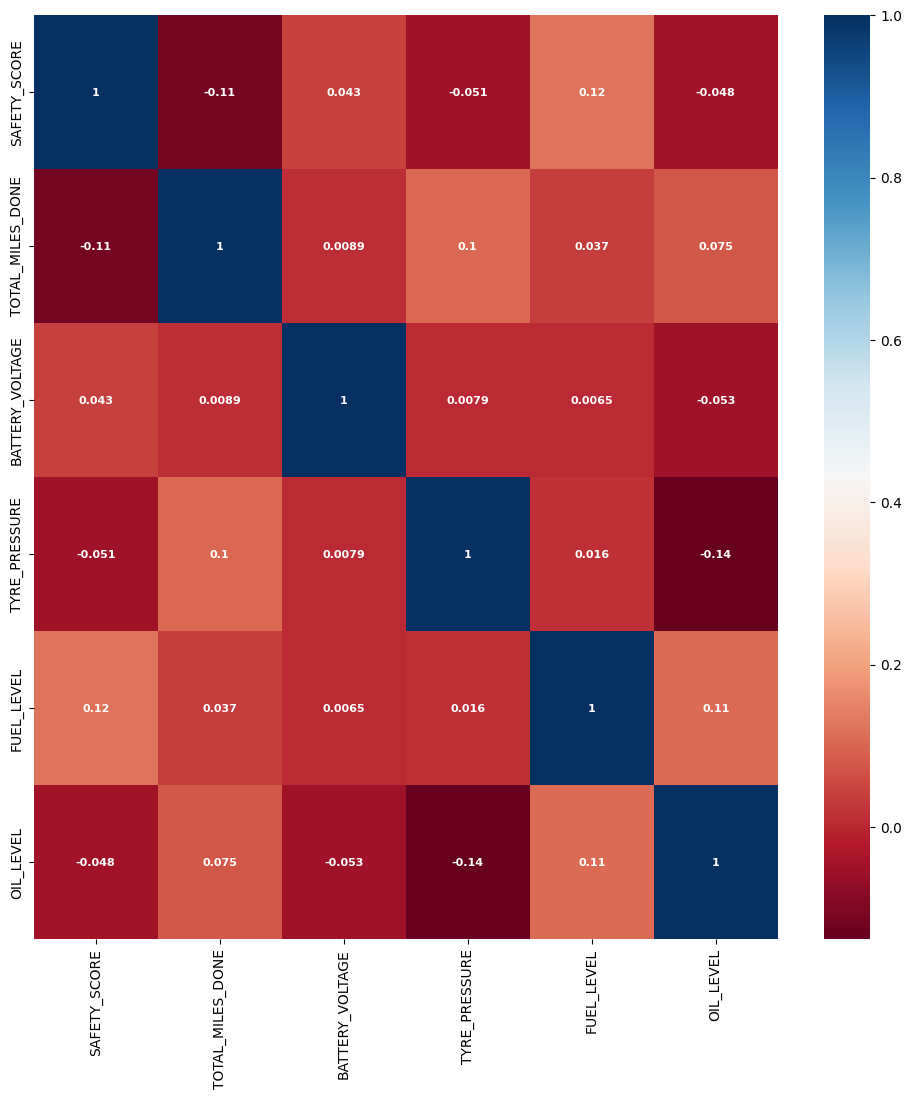

In [16]:
df=pd.read_csv("vehicle.csv")
columns_list=list(df.columns)

corr_columns=columns_list[3:4]+columns_list[7:8]+columns_list[10:14]
corr_df=df[corr_columns]

corr=corr_df.corr()
plt.figure(figsize=((12,12)))
sns.heatmap(corr, cmap='RdBu', annot=True, annot_kws={'fontsize':8, 'fontweight':'bold'})
plt.show()

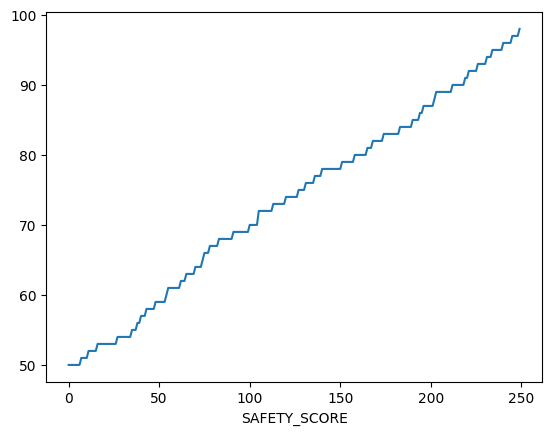

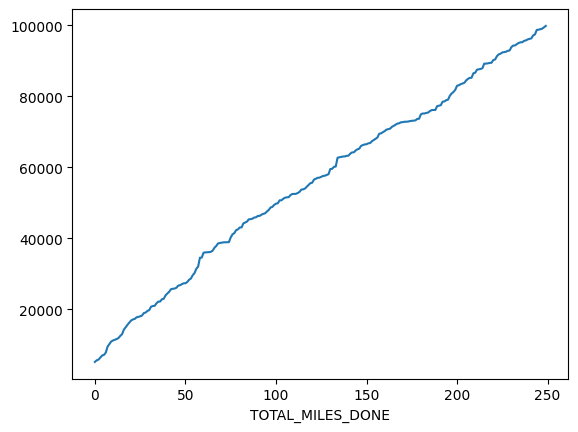

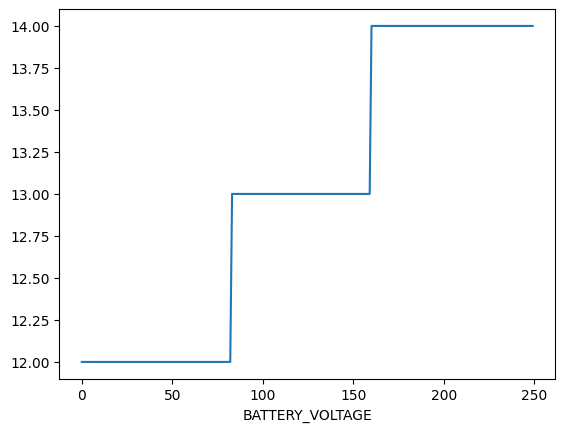

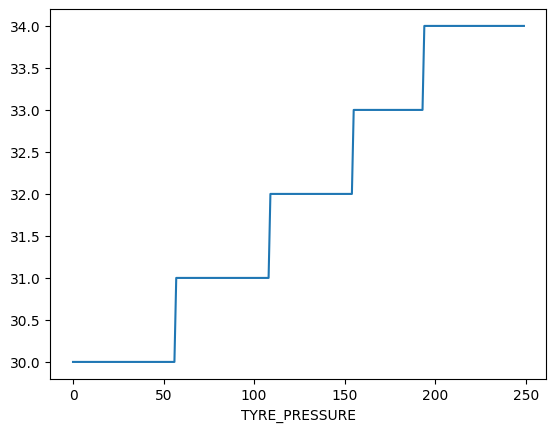

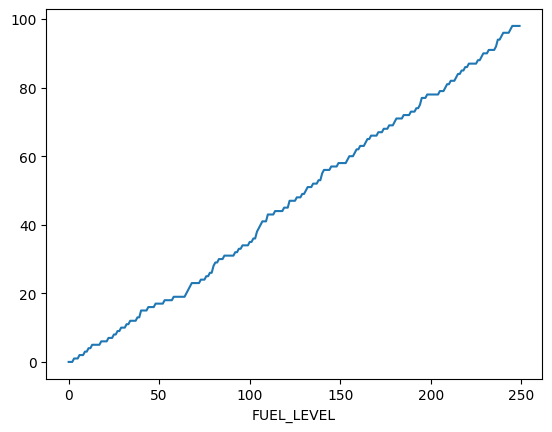

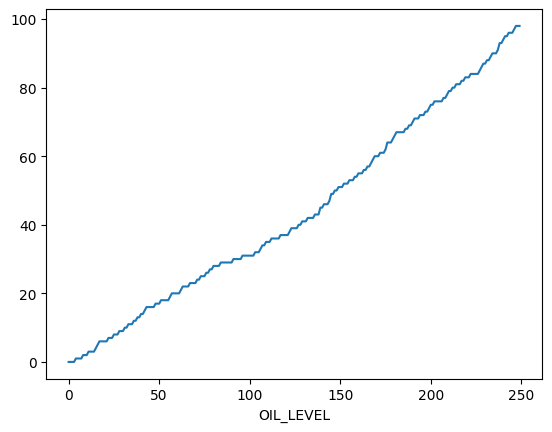

In [17]:
df=pd.read_csv("vehicle.csv")
columns_list=list(df.columns)

for col in corr_columns:
    column=np.array(df[col])
    column.sort()
    plt.plot(column)
    plt.xlabel(col)
    plt.show()

In [18]:
df=pd.read_csv("vehicle.csv")
columns_list=list(df.columns)

num_columns=corr_columns
norm_df=df[num_columns]

scaler=MinMaxScaler()
norm_df[num_columns]=scaler.fit_transform(norm_df[num_columns])

In [19]:
x_col=['TOTAL_MILES_DONE', 'BATTERY_VOLTAGE', 'TYRE_PRESSURE', 'FUEL_LEVEL', 'OIL_LEVEL']

X_df=norm_df[x_col]
Y_df=norm_df["SAFETY_SCORE"]

X_train, X_testval, Y_train, Y_testval = train_test_split(X_df, Y_df, test_size=0.3, random_state=0)
X_test, X_val, Y_test, Y_val = train_test_split(X_testval, Y_testval, test_size=0.5, random_state=22)

model=LinearRegression()
model.fit(X_train, Y_train)
Y_pred=model.predict(X_test)

x_coef=dict(np.array([x_col, model.coef_]).T)
print(x_coef)

print("Score of Linear Regression:", explained_variance_score(Y_test, Y_pred))

{'TOTAL_MILES_DONE': '-0.13119344316183648', 'BATTERY_VOLTAGE': '0.05162292889381284', 'TYRE_PRESSURE': '-0.15240825730039698', 'FUEL_LEVEL': '0.11157358829719734', 'OIL_LEVEL': '-0.06629092327713924'}
Score of Linear Regression: -0.03027178539874109


# Trip Data

In [20]:
df=pd.read_csv("route.csv")
display(df)

,ROUTE_ID,SOURCE,DESTINATIONS,GEOPOINTS,AVG_RISK_SCORE,RAIN,TEMP,PRESSURE,WIND_SPEED,WIND_DIRECTION
0,10,"[33.4197323, -112.0353126]",85035,"[[33.4197696, 33.4197696, 33.4182544, -112.034...",83,6,46,67,38,6
1,11,"[33.4389855732, -112.2094626767]",85011,"[[33.4393186, 33.4393186, 33.4393101, -112.212...",87,0,22,82,28,2
2,12,"[33.4197323, -112.0353126]",85083,"[[33.4197696, 33.4197696, 33.4182544, -112.034...",71,5,64,66,30,7
3,13,"[33.4346542, -112.227478]",85008,"[[33.4358304, 33.4358304, 33.4358243, -112.229...",64,3,39,60,9,2
4,14,"[33.4346542, -112.227478]",85002,"[[33.4358304, 33.4358304, 33.4358243, -112.229...",62,3,15,85,7,6
...,...,...,...,...,...,...,...,...,...,...
70,80,"[33.4186296, -111.995826]",85034,"[[33.4186299, 33.4186299, 33.4115216, -111.995...",81,9,34,69,16,6
71,81,"[33.4389855732, -112.2094626767]",85035,"[[33.4393186, 33.4393186, 33.4393101, -112.212...",50,8,55,55,12,3
72,82,"[33.4389855732, -112.2094626767]",85036,"[[33.4393186, 33.4393186, 33.4393101, -112.212...",70,2,40,64,4,3
73,83,"[33.445266034, -111.946192139]",85036,"[[33.444216, 33.444216, 33.4447187, -111.94833...",80,7,51,75,45,4


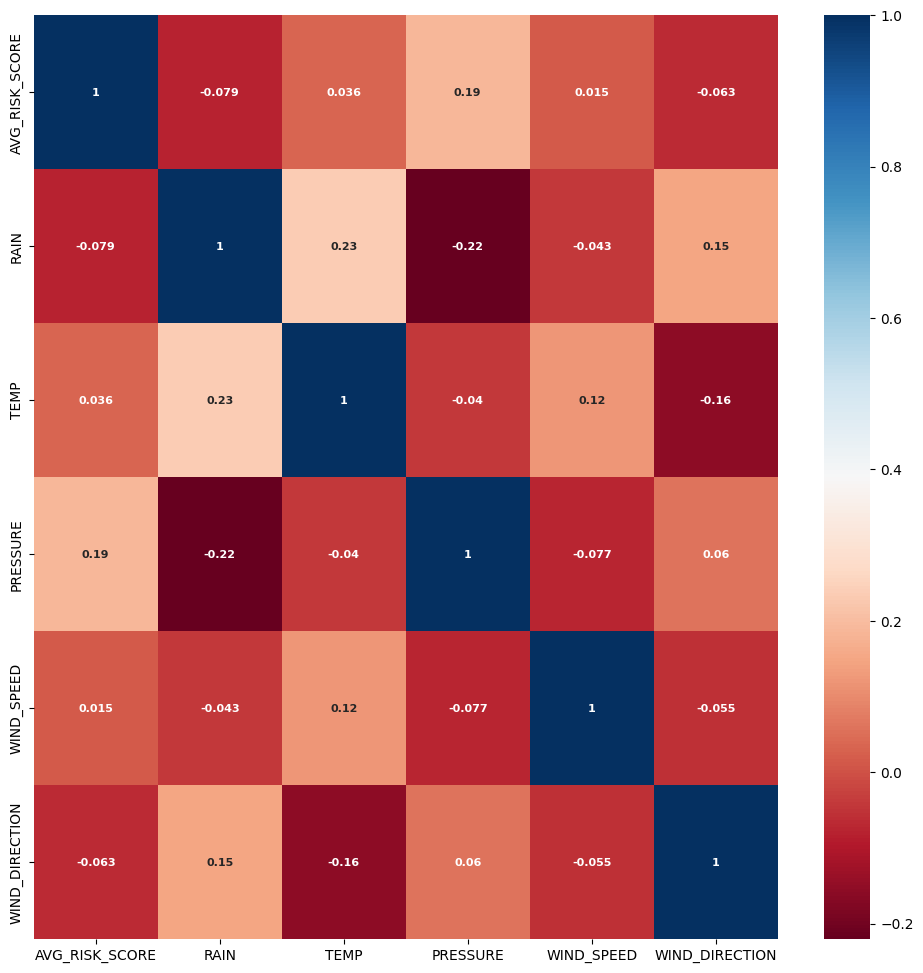

In [22]:
df=pd.read_csv("route.csv")
columns_list=list(df.columns)

corr_columns=['AVG_RISK_SCORE', 'RAIN', 'TEMP', 'PRESSURE', 'WIND_SPEED', 'WIND_DIRECTION']
corr_df=df[corr_columns]

corr=corr_df.corr()
plt.figure(figsize=((12,12)))
sns.heatmap(corr, cmap='RdBu', annot=True, annot_kws={'fontsize':8, 'fontweight':'bold'})
plt.show()

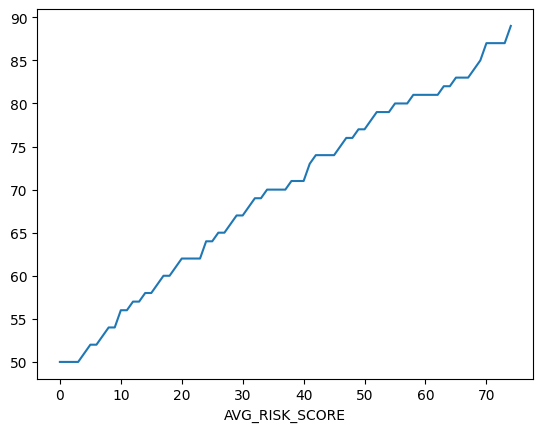

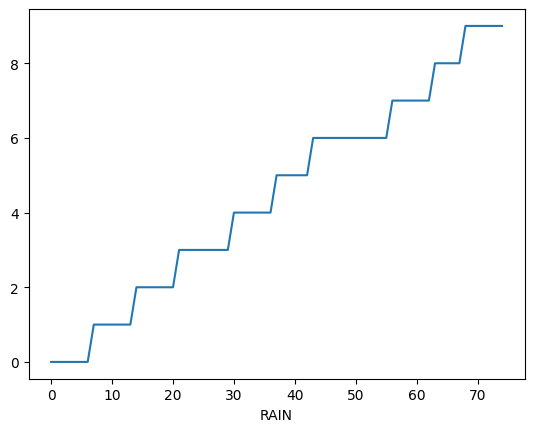

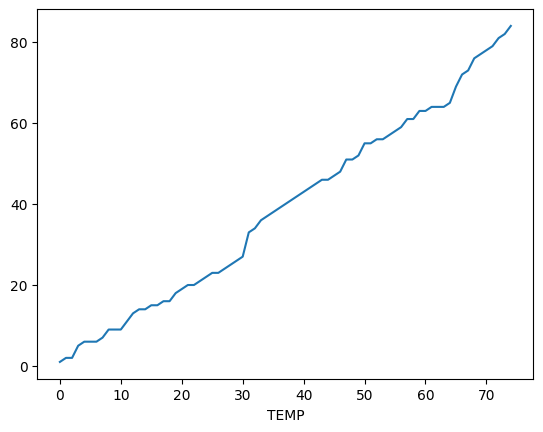

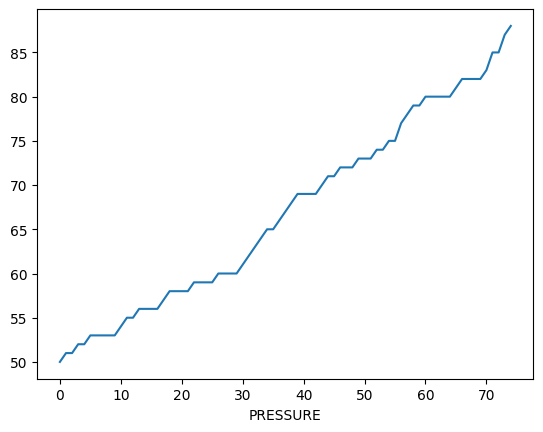

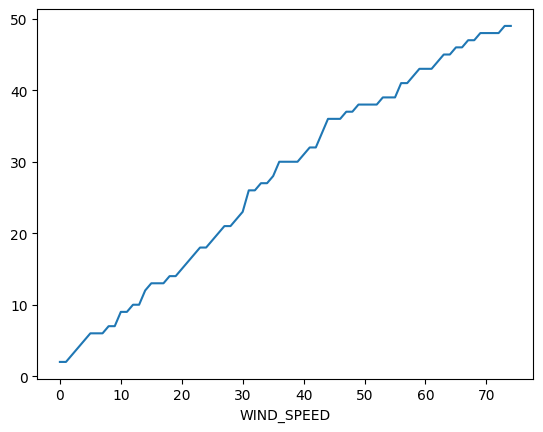

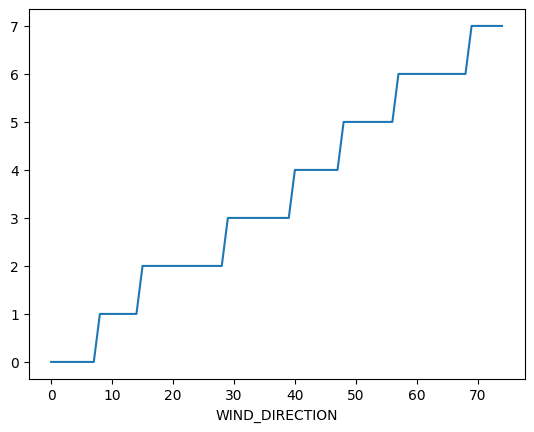

In [23]:
for col in corr_columns:
    column=np.array(df[col])
    column.sort()
    plt.plot(column)
    plt.xlabel(col)
    plt.show()